##Objective: build a classificationn model that uses biased and unbiased text material. This is an attempt to improve upon the Naive Bayes model which resulted in a low F-1 and accuracy scores.

##Written by: Etienne Ndedi
##Date: 10-14-2024

##Readme#
- The source data set is a cleaned and stored version of the biased.full        
  dataset sourced from the WIKI NEUTRALITY CORPUS subset downloaded from Kaggle. Examples and Labels have been generated in the CAPSTONE_GENERATE_EXAMPLES_AND_LABELS.ipynb code found in the current directory

- As a reminder the GPT-2 model is reliant on the last vector of the vectorized
  tokens to which a linear layer with a Sigmoid activation is added on top of to generate the prediction. Thi is what will be implemented here for our classification of bias/no bias

- Pytorch and not Tensorflow will be the framework in the code.

Install our libraries

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
#from datasets import load_dataset

#ultimately we want the model and data be stored in GPU, that's what cuda means
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

Now, let's load the sentence transformer

In [ ]:
%%capture
!pip install -U sentence-transformers
!pip install portalocker
!pip install transformers
from transformers import GPT2Tokenizer##
from sentence_transformers import SentenceTransformer
import numpy as np #using Numpy in case we want to switch to it from Torch

Let's download the GPT-2 tokenizer and Model

In [ ]:
%%capture
from transformers import AutoTokenizer, GPT2Model, GPT2ForSequenceClassification

gpt_2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2") ##
gpt_2_tokenizer.add_special_tokens({'pad_token': '[PAD]'}) ##
gpt_2_model = GPT2Model.from_pretrained("gpt2").to(device)
sentence_embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').to(device)

Now, let's load our bias_train_full data set

- Preprocessing will be needed to create a dataset that is consistent with the
  pytorch class requirements.
- Then create a dataloader that we could use to iterate for for batching and
  shuffling.

In [ ]:
#Read the data set

import pandas as pd
import csv

bias_train_full = pd.read_csv("/content/bias_train_full.csv", on_bad_lines='skip', engine='python')

bias_train_full.head()

,id,src_tok,tgt_tok,src_raw,tgt_raw,src_POS_tags,tgt_parse_tags
0,79229477,when interviewed on britain ' s most popular a...,when interviewed on britain ' s popular talk s...,when interviewed on britain's most popular and...,when interviewed on britain's popular talk sho...,ADV VERB ADP NOUN PUNCT VERB ADV ADJ CCONJ ADJ...,advmod advcl prep pobj punct dobj advmod amod ...
1,11880865,prior to the 2004 u . s . presidential electio...,prior to the 2004 u . s . presidential electio...,prior to the 2004 u.s. presidential election h...,prior to the 2004 u.s. presidential election h...,ADV ADP DET NUM NOUN PUNCT VERB PUNCT ADJ NOUN...,advmod prep det pobj ROOT punct punct punct am...
2,151712490,"mcc ##our ##t ' s sar ##tori ##al sense was , ...","mcc ##our ##t ' s sar ##tori ##al sense was , ...","mccourt's sartorial sense was, like many from ...","mccourt's sartorial sense was, like many from ...",NOUN NOUN NOUN PUNCT PART ADJ ADJ ADJ NOUN VER...,advmod advmod advmod punct nummod amod amod am...
3,11526673,these techniques ( which have not been proven ...,"these techniques , include "" brain ##wash ##in...",these techniques (which have not been proven s...,"these techniques, include ""brainwashing"", ""tho...",DET NOUN PUNCT ADJ VERB ADV VERB VERB ADV ADV ...,det nsubj punct nsubjpass aux neg auxpass relc...
4,175686181,also included in the portfolio : a successful ...,also included in the portfolio are a maritime ...,also included in the portfolio : a successful ...,also included in the portfolio are a maritime ...,ADV VERB ADP DET NOUN PUNCT DET ADJ NOUN NOUN ...,advmod ROOT prep det pobj punct det amod amod ...


In [ ]:
len(bias_train_full)

119770

NOW WE NEED TO BINARIZE THE TRAIN DATA SET

In [ ]:
#Create a data set that consists of two columns, df_inputs['plots'] a concatenation of df_inputs['src_raw'] and df_inputs['tgt_raw']
df_new = pd.DataFrame(columns=['plots', 'labels'])

#Create two data sets, one with df_inputs['src_raw'] another with df_inputs['tgt_raw']
df_src = bias_train_full['src_raw']
df_tgt = bias_train_full['tgt_raw']

#rename df_tgt to 'example'
df_tgt = df_tgt.rename('example') # Changed 'columns' to 'name' for Series
#create a variable df_tgt['label'] with value 0
df_tgt = df_tgt.to_frame() # Convert Series to DataFrame to add a new column
df_tgt['label'] = 0
#rename df_src to 'example'
df_src = df_src.rename('example') # Changed 'columns' to 'name' for Series
#create a variable df_src['label'] with value 1
df_src = df_src.to_frame() # Convert Series to DataFrame to add a new column
df_src['label'] = 1
# Concatenate df_src and df_tgt to have a larger data set that we will shuffle
# This data set bias_unbias will have both the positive and negative labels
bias_unbias = pd.concat([df_src, df_tgt])
# Shuffle the data set
bias_unbias_train = bias_unbias.sample(frac=1).reset_index(drop=True)

# Print the number of rows in the DataFrame
print(f"Number of rows in DataFrame: {len(bias_unbias_train)}")

# Print the number of columns in the DataFrame
print(f"Number of columns in DataFrame: {len(bias_unbias_train.columns)}")

# Print the counts of the label column
print(bias_unbias_train['label'].value_counts())

# Print the first few rows of the DataFrame
bias_unbias_train.head()

Number of rows in DataFrame: 239540
Number of columns in DataFrame: 2
label
1    119770
0    119770
Name: count, dtype: int64


,example,label
0,the winter soldier investigation (wsi) was org...,1
1,"on june 5, 2011, two days before nintendo's e3...",0
2,to celebrate the 80th birthdays of both laine ...,1
3,"in the 1929 palestine riots, women took part i...",1
4,"pope pius ix is elected pope, beginning the lo...",1


Now we could either take the whole data set or just a portion of it. At this juncture there are no balancing issues as the plots columns and labels came from
two columns sourced from the same subset named biased.full

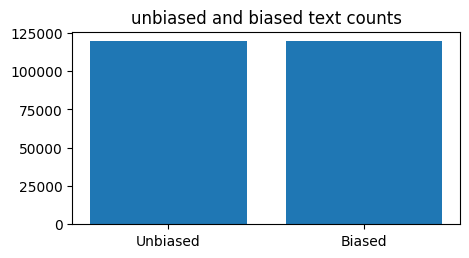

In [ ]:
label_names = ['Unbiased', 'Biased']
labels_names = bias_unbias_train['label'].value_counts()
title = 'unbiased and biased text counts'
plt.figure(figsize=(5,2.5))
plt.title(title)
plt.bar(label_names, labels_names)
plt.show()

A few values

In [ ]:
bias_unbias_train[:3]

,example,label
0,the winter soldier investigation (wsi) was org...,1
1,"on june 5, 2011, two days before nintendo's e3...",0
2,to celebrate the 80th birthdays of both laine ...,1


Continue Processing Training data

In [ ]:
V_keys = pd.DataFrame(bias_unbias_train['example'])
V_keys = V_keys['example'].to_list()
V_keys = pd.Series(V_keys, name = 'text')

V_values = pd.DataFrame(bias_unbias_train['label'])
V_values = V_values['label'].to_list()
V_values = pd.Series(V_values, name = 'label')

In [ ]:
!pip install datasets
from datasets import Dataset

# Create an empty dictionary
res = {}
# Convert V_values to a list for easier iteration and removal
V_values_list = V_values.tolist()

#Now create a dictionary with the series names 'text and 'label'
res = {'text': V_keys, 'label': V_values}

#create a dictionary of the elements of res
all_dict = dict(res)

#store all_dict using Dataset module
my_train_dataset = Dataset.from_dict(all_dict)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# Print the device information
print(f"Using device: {device}")

Using device: cuda


**DO SAME MASSAGING FOR TEST DATA**
Again this processing is to make it easier to use pytorch which is a little more flexible and transparent than Tensorflow

In [ ]:
bias_test_full = pd.read_csv("/content/bias_test_full.csv", on_bad_lines='skip', engine='python')
len(bias_test_full)

25666

In [ ]:
#Create two data sets, one with df_inputs['src_raw'] another with df_inputs['tgt_raw']
df_src = bias_test_full['src_raw']
df_tgt = bias_test_full['tgt_raw']

#rename df_tgt to 'example'
df_tgt = df_tgt.rename('example') # Changed 'columns' to 'name' for Series
#create a variable df_tgt['label'] with value 0
df_tgt = df_tgt.to_frame() # Convert Series to DataFrame to add a new column
df_tgt['label'] = 0
#rename df_src to 'example'
df_src = df_src.rename('example') # Changed 'columns' to 'name' for Series
#create a variable df_src['label'] with value 1
df_src = df_src.to_frame() # Convert Series to DataFrame to add a new column
df_src['label'] = 1
# Concatenate df_src and df_tgt to have a larger data set that we will shuffle
# This data set bias_unbias will have both the positive and negative labels
bias_unbias_test = pd.concat([df_src, df_tgt])
# Shuffle the data set
bias_unbias_test = bias_unbias_test.sample(frac=1).reset_index(drop=True)

# Print the number of rows in the DataFrame
print(f"Number of rows in DataFrame: {len(bias_unbias_test)}")

# Print the number of columns in the DataFrame
print(f"Number of columns in DataFrame: {len(bias_unbias_test.columns)}")

# Print the counts of the label column
print(bias_unbias_test['label'].value_counts())

# Print the first few rows of the DataFrame
bias_unbias_test.head()

Number of rows in DataFrame: 51332
Number of columns in DataFrame: 2
label
0    25666
1    25666
Name: count, dtype: int64


,example,label
0,livestock suffered greatly due to the barn fai...,0
1,president bush's declaration and prosecution o...,0
2,the rights for syncit.com was taken over by ja...,0
3,"in earthly powers, german, or perhaps its soun...",0
4,"also, gaius pontius is commonly believed to be...",0


##Continue processing test data

In [ ]:
V_keys = pd.DataFrame(bias_unbias_test['example'])
V_keys = V_keys['example'].to_list()
V_keys = pd.Series(V_keys, name = 'text')

V_values = pd.DataFrame(bias_unbias_test['label'])
V_values = V_values['label'].to_list()
V_values = pd.Series(V_values, name = 'label')

In [ ]:
!pip install datasets
from datasets import Dataset
# Create an empty dictionary
res = {}
# Convert V_values to a list for easier iteration and removal
V_values_list = V_values.tolist()

#Now create a dictionary with the series names 'text and 'label'
res = {'text': V_keys, 'label': V_values}

#create a dictionary of the elements of res
all_dict = dict(res)

#store all_dict using Dataset module
my_test_dataset = Dataset.from_dict(all_dict)

DO SAME MASSAGING FOR VALIDATION DATA

In [ ]:
bias_val_full = pd.read_csv("/content/bias_val_full.csv", on_bad_lines='skip', engine='python')
len(bias_val_full)

25665

In [ ]:
#Create two data sets, one with df_inputs['src_raw'] another with df_inputs['tgt_raw']
df_src = bias_val_full['src_raw']
df_tgt = bias_val_full['tgt_raw']

#rename df_tgt to 'example'
df_tgt = df_tgt.rename('example') # Changed 'columns' to 'name' for Series
#create a variable df_tgt['label'] with value 0
df_tgt = df_tgt.to_frame() # Convert Series to DataFrame to add a new column
df_tgt['label'] = 0
#rename df_src to 'example'
df_src = df_src.rename('example') # Changed 'columns' to 'name' for Series
#create a variable df_src['label'] with value 1
df_src = df_src.to_frame() # Convert Series to DataFrame to add a new column
df_src['label'] = 1
# Concatenate df_src and df_tgt to have a larger data set that we will shuffle
# This data set bias_unbias will have both the positive and negative labels
bias_unbias_val = pd.concat([df_src, df_tgt])
# Shuffle the data set
bias_unbias_val = bias_unbias_val.sample(frac=1).reset_index(drop=True)

# Print the number of rows in the DataFrame
print(f"Number of rows in DataFrame: {len(bias_unbias_val)}")

# Print the number of columns in the DataFrame
print(f"Number of columns in DataFrame: {len(bias_unbias_val.columns)}")

# Print the counts of the label column
print(bias_unbias_val['label'].value_counts())

# Print the first few rows of the DataFrame
bias_unbias_val.head()

Number of rows in DataFrame: 51330
Number of columns in DataFrame: 2
label
0    25665
1    25665
Name: count, dtype: int64


,example,label
0,"hormuzd khambata is an indian choreographer , ...",0
1,... that stephen hawking and leonard mlodinow ...,0
2,while edward the confessor had an english neph...,1
3,this has reduced the number of citizens who id...,1
4,marco polo (september 15 1254 – january 8 1324...,0


In [ ]:
V_keys = pd.DataFrame(bias_unbias_val['example'])
V_keys = V_keys['example'].to_list()
V_keys = pd.Series(V_keys, name = 'text')

V_values = pd.DataFrame(bias_unbias_val['label'])
V_values = V_values['label'].to_list()
V_values = pd.Series(V_values, name = 'label')

In [ ]:
!pip install datasets
from datasets import Dataset
# Create an empty dictionary
res = {}
# Convert V_values to a list for easier iteration and removal
V_values_list = V_values.tolist()

#Now create a dictionary with the series names 'text and 'label'
res = {'text': V_keys, 'label': V_values}

#create a dictionary of the elements of res
all_dict = dict(res)

#store all_dict using Dataset module
my_val_dataset = Dataset.from_dict(all_dict)

In [ ]:
#####################################

Continue processing

In [ ]:
my_train_dataset[2]

{'text': 'to celebrate the 80th birthdays of both laine and dankworth, union square music released the four disc box set i hear music the most comprehensive and lovingly produced examination of their careers ever assembled: disc 1: early days (194456), disc 2: john, big band and the movies (195674), disc 3: focus on cleo (195591), disc 4: a family affair (including recordings made with their children, alec and jacqui, from 1982 to 2005).',
 'label': 1}

In [ ]:
my_test_dataset[2]

{'text': 'the rights for syncit.com was taken over by jack dean who runs sync2it.com, syncit.com and bookmarksync.com he has developed a new client for latest browsers including firefox and mac platform, and works to continue this service.',
 'label': 0}

In [ ]:
my_val_dataset[2]

{'text': 'while edward the confessor had an english nephew who might have qualified as his successor, he could not become king because he was too young to protect himself, let alone a country .',
 'label': 1}

In [ ]:
#ultimately we want the model and data be stored in GPU, that's what cuda means
print(f"Using device: {device}")

Using device: cuda


In [ ]:
###########################

NOW STARTING TRAINING AND TESTING HERE

In [ ]:
my_datasets = {'train': my_train_dataset.select_columns(['text','label']),
               'test': my_test_dataset.select_columns(['text','label']),
               'valid': my_val_dataset.select_columns(['text','label'])}

In [ ]:
my_datasets.keys()

dict_keys(['train', 'test', 'valid'])

In [ ]:
my_datasets['test'].features #######DIFFERENT HERE ###############

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [ ]:
my_datasets['train'].features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [ ]:
my_datasets['valid'].features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [ ]:
def create_temp_set(base_data, num_examples=1000000000):
    num_positive = 0
    num_negative = 0
    num_other = 0

    temp_data = []
    out_data = []

    for example_num, example in enumerate(base_data):

      temp_data.append(example)

    random.shuffle(temp_data)

    for example_num, example in enumerate(temp_data):

      if num_examples != -1 and example_num > num_examples:
        break

      if example['label'] == 0:
        num_negative += 1
      elif example['label'] == 1:
        num_positive += 1
      else:
        num_other += 1

      out_data.append(example)


    print('positive: ', num_positive)
    print('negative: ', num_negative)
    print('other: ', num_other)

    return out_data

In [ ]:
my_train_data = create_temp_set(my_datasets['train'], 100000000)
my_test_data = create_temp_set(my_datasets['test'], 2000000)
my_val_data = create_temp_set(my_datasets['valid'], 2000000)


positive:  119770
negative:  119770
other:  0
positive:  25666
negative:  25666
other:  0
positive:  25665
negative:  25665
other:  0


In [ ]:
[x for x in my_train_dataset['label'][:10]]

[1, 0, 1, 1, 1, 0, 1, 1, 1, 0]

In [ ]:
[x for x in my_train_dataset['text'][:2]]

['the winter soldier investigation (wsi) was organized to demonstrate that incidents like my lai were not isolated and rare occurrences, but were instead the frequent and predictable result of official american war policy.',
 'on june 5, 2011, two days before nintendo\'s e3 2011 press conference, game informer, which had previously referred to the console as "nintendo hd," speculated that the final name for the console may be simply nintendo.']

In [ ]:
[x for x in my_train_dataset[:2]]

['text', 'label']

Now Create a list of libraries for the data loaders

In [ ]:
#create a long list of libraries for my dataloader to ingest text and label
#my_train_dataset = [x for x in my_train_dataset]

We will now create the actual Dataset and the Dataloader.

We will use the Dataset definition to properly format the data:

* we will ignore examples that do not have our desired minimum length

In [ ]:
class ClassificationData(Dataset):
    def __init__(self, base_data, tokenizer, max_len, use_prompt=False):
        self.max_len = max_len
        self.tokenizer = tokenizer  # assume that padding token has already been added to tokenizer
        self.datat = []


        # really  not ideal having to iterate through the whole set. But ok for this small data volume
        for example_num, example in enumerate(base_data):


            try:
              token_encoder = tokenizer(example['text'])['input_ids']
            except:
              print(example_num)
              break

            try:
              if len(token_encoder) <= self.max_len:
                continue    # avoids complications with short sentences. No padding is needed then.
            except:
              print(example_num)
              print(token_encoder)
              print(len(token_encoder))
              break

            truncated_encoding = token_encoder[:self.max_len]
            truncated_example = tokenizer.decode(truncated_encoding) # reconstruct shortened review

            # LLMs do next-word predictions. You may want to add a prompt that the model can work with!

            if use_prompt:
                cutoff = self.max_len + 13
                prompted_text_line = 'Here is a text to check bias on: ' + truncated_example + ' Is this text bias or unbiased?'

            else:
                cutoff = self.max_len
                prompted_text_line = truncated_example

            if len(gpt_2_tokenizer(prompted_text_line)['input_ids']) != cutoff:
                    continue

            tokenized_example = self.tokenizer(prompted_text_line,
                                               return_tensors="pt",
                                               max_length=cutoff,
                                               truncation=True,
                                               padding='max_length').to(device)
#putting the label in the device just as the tokenized text
            self.datat.append({'label': (float(example['label'])),
                              'tokenized_text':
                                  {'input_ids': torch.tensor(torch.squeeze(tokenized_example['input_ids']),
                                      device=device),
                                   'attention_mask': torch.tensor(torch.squeeze(tokenized_example['attention_mask']),
                                      device=device)
                                   }
                              })

    def __len__(self):
        return len(self.datat)

    def __getitem__(self, index):

        return {
            'input': self.datat[index]['tokenized_text'],
            'label': torch.tensor(self.datat[index]['label'],
                                  dtype=torch.float,device=device
                                  )
        }

In [ ]:
train_data = ClassificationData(my_train_dataset, tokenizer=gpt_2_tokenizer, max_len=100)
test_data = ClassificationData(my_test_dataset, tokenizer=gpt_2_tokenizer, max_len=100)
valid_data = ClassificationData(my_val_dataset, tokenizer=gpt_2_tokenizer, max_len=100)


<ipython-input-76-3afeae450b44>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  {'input_ids': torch.tensor(torch.squeeze(tokenized_example['input_ids']),
<ipython-input-76-3afeae450b44>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(torch.squeeze(tokenized_example['attention_mask']),


In [ ]:
train_data[0] ###SAME UP TO HERE##############################################

{'input': {'input_ids': tensor([ 1462, 10648,   262,  4019,   400,  4082, 12545,   286,  1111,   300,
           5718,   290,   288,   962,  9268,    11,  6441,  6616,  2647,  2716,
            262,  1440,  1221,  3091,   900,  1312,  3285,  2647,   262,   749,
           9815,   290, 42900,  4420,  4635, 12452,   286,   511, 16179,  1683,
          16030,    25,  1221,   352,    25,  1903,  1528,   357, 22913, 29228,
            828,  1221,   362,    25, 45610,    11,  1263,  4097,   290,   262,
           6918,   357, 22186, 45385,   828,  1221,   513,    25,  2962,   319,
           1190,    78,   357,  1129,  2816,  6420,   828,  1221,   604,    25,
            257,  1641, 14669,   357,  8201, 18813,   925,   351,   511,  1751,
             11, 31341,    66,   290,   474, 43561,    72,    11,   422, 14489],
         device='cuda:0'),
  'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
# Print the device information
print(f"Using device: {device}")

Using device: cuda


In [ ]:
#I need only the  'input' and 'label' from train_data and test_data that fit into the dataloader

train_data = [train_data[i] for i in range(len(train_data))]
test_data = [test_data[i] for i in range(len(test_data))]
valid_data = [valid_data[i] for i in range(len(valid_data))]

In [ ]:
batch_size = 16
train_texts = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_texts = DataLoader(test_data, batch_size=batch_size, shuffle=True)
valid_texts = DataLoader(valid_data, batch_size=batch_size, shuffle=True)

In [ ]:
##########################

In [ ]:
# Iterate through the DataLoader to access batches
for batch in train_texts:
  # Check if 'input' key exists and is a Tensor
  if 'input' in batch and isinstance(batch['input'], torch.Tensor):
    # Move 'input' tensor to the device
    batch['input'] = batch['input'].to(device)
    # Check if 'label' key exists and is a Tensor
    if 'label' in batch and isinstance(batch['label'], torch.Tensor):
      # Move 'label' tensor to the device
      batch['label'] = batch['label'].to(device)
  # Process the batch here...

In [ ]:
# Iterate through the DataLoader to access batches
for batch in test_texts:
  # Check if 'input' key exists and is a Tensor
  if 'input' in batch and isinstance(batch['input'], torch.Tensor):
    # Move 'input' tensor to the device
    batch['input'] = batch['input'].to(device)
    # Check if 'label' key exists and is a Tensor
    if 'label' in batch and isinstance(batch['label'], torch.Tensor):
      # Move 'label' tensor to the device
      batch['label'] = batch['label'].to(device)
  # Process the batch here...

In [ ]:
# Iterate through the DataLoader to access batches
for batch in valid_texts:
  # Check if 'input' key exists and is a Tensor
  if 'input' in batch and isinstance(batch['input'], torch.Tensor):
    # Move 'input' tensor to the device
    batch['input'] = batch['input'].to(device)
    # Check if 'label' key exists and is a Tensor
    if 'label' in batch and isinstance(batch['label'], torch.Tensor):
      # Move 'label' tensor to the device
      batch['label'] = batch['label'].to(device)
  # Process the batch here...

In [ ]:
# Print the device information
print(f"Using device: {device}")

Using device: cuda


In [ ]:
##########################################

In [ ]:
next(iter(test_texts)).keys()

dict_keys(['input', 'label'])

In [ ]:
next(iter(valid_texts)).keys()

dict_keys(['input', 'label'])

Now let's set up our neural network model for gpt-2 classification
We could use it as the first layer in our network, where we use the input_ids as input, then use the last output vector as input to the classification layer.

Remeber the last vector has information about all other previous vectors, that is how GPT-2 works in classification (unlike BERT)

In [ ]:
class MyBiasClassificationNetworkClass(torch.nn.Module):
    def __init__(self, embedding_model, embedding_model_dim):
        super().__init__()
        self.lm = embedding_model
        self.dropout = torch.nn.Dropout(0.2)
        self.linear_2 = torch.nn.Linear(embedding_model_dim, 1)
        self.sigmoid = torch.nn.Sigmoid()


    def forward(self, x):                            #The x is that input we act on layer
        embeddings = self.lm(**x)['last_hidden_state'][:, -1]
        dropout_embeddings = self.dropout(embeddings)
        output = self.linear_2(dropout_embeddings)[:, 0] #flatten the last dimension
        output = self.sigmoid(output)
        return output

my_Bias_classification_network = MyBiasClassificationNetworkClass(embedding_model=gpt_2_model,
                                                                  embedding_model_dim=768)

my_Bias_classification_network.to(device)

MyBiasClassificationNetworkClass(
  (lm): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (linear_2): Linear(in_features=768, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
# Print the device information
print(f"Using device: {device}")

Using device: cuda


Let's see if this architecture works

In [ ]:
example=next(iter(train_texts))
example

{'input': {'input_ids': tensor([[43588,  1845,   591,  ..., 35429,    11,  1588],
          [  259,   262,  1285,  ...,    11,  1474,   256],
          [38169,   284,   617,  ...,   262, 26355,   286],
          ...,
          [ 5661,    11,  3017,  ...,   284,   595,  5372],
          [   69,  5943, 31341,  ...,  2831,   290,  1597],
          [  270,   318,   530,  ...,  1330,  1220, 10784]], device='cuda:0'),
  'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]], device='cuda:0')},
 'label': tensor([0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1.],
        device='cuda:0')}

Below are the first 16 predictions as each batch has 16 examples. Just wanted to see if the architecture works fine first.

In [ ]:
print(my_Bias_classification_network(example['input']))

tensor([8.3740e-04, 7.2836e-02, 7.4688e-05, 1.1146e-02, 5.1659e-02, 3.7273e-01,
        8.3957e-06, 9.4671e-04, 5.7606e-01, 4.8848e-06, 1.5368e-03, 3.5585e-02,
        3.1147e-04, 2.0252e-03, 5.6299e-05, 4.9753e-06], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Now we need to set up 2 things namely: the loss function and the optimizer to have all of our building block for training. We want to use the binary cross-entropy and the Adam optimizer.

In [ ]:
loss_fn = torch.nn.BCELoss().to(device)
adam_optimizer = torch.optim.Adam(my_Bias_classification_network.parameters(), lr=0.0001)

Let's test whether the loss function works for our labels and model outputs.

In [ ]:
sample_example = next(iter(train_texts))
sample_input = sample_example['input']
sample_labels = sample_example['label'].to(device)

sample_labels

tensor([1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       device='cuda:0')

The number below is the average loss that needs to be validated

In [ ]:
sample_output = my_Bias_classification_network(sample_input).to(device)

loss_fn(sample_output, sample_labels).to(device)

tensor(3.4108, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

In [ ]:
sample_output

tensor([1.0005e-02, 7.3396e-05, 1.9025e-05, 4.0941e-01, 7.0652e-06, 1.8628e-03,
        2.1046e-06, 1.8051e-03, 8.1955e-06, 4.6357e-05, 4.4481e-04, 4.8912e-03,
        3.4951e-05, 2.9443e-05, 3.0319e-04, 4.7829e-03], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

We could get the labels and then calculate manually just to check based on the formula for the loss function in the context of binary classification.

In [ ]:
print('Labels: ', sample_labels)
print('Sample Output: ', sample_output)

Labels:  tensor([1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       device='cuda:0')
Sample Output:  tensor([1.0005e-02, 7.3396e-05, 1.9025e-05, 4.0941e-01, 7.0652e-06, 1.8628e-03,
        2.1046e-06, 1.8051e-03, 8.1955e-06, 4.6357e-05, 4.4481e-04, 4.8912e-03,
        3.4951e-05, 2.9443e-05, 3.0319e-04, 4.7829e-03], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


Here is the manual calculation, that needs to match the average loss above. Just doing this to ensure that the function is validated by the manual calculation of the average loss

In [ ]:
sample_output_list = list(sample_output.cpu().detach().numpy())
sample_labels_list = list(sample_labels.cpu().detach().numpy())

loss = 0

for (label, positive_class_prob) in zip(sample_labels_list, sample_output_list):
  if label == 0:
    loss -= np.log(1 - positive_class_prob)
  else:
    loss -= np.log(positive_class_prob)

average_loss = loss/len(sample_labels_list)



print('Manual binary cross entropy discussion: ', average_loss)

Manual binary cross entropy discussion:  3.410766555087789


Now, we have to use the loops to complete training and validation. Pytorch requires we use model.train() and validation requires we use model.eval() for the loop in which backpropagation will be used for training and not for evaluation.

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, reporting_interval=25, steps=None):
    # size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    epoch_loss = 0
    model.train()

    for batch, example in enumerate(dataloader):

      X =  example['input']
      y = example['label']

      if steps is not None:
        if batch > steps:
          break

      optimizer.zero_grad()     # the gradients need to be zeroed out after the gradients are applied by the optimizer

      # Compute prediction and loss

      pred = model(X)

      loss = loss_fn(pred, y)

      # Backpropagation
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()

      if int(batch + 1) % reporting_interval == 0:
        print('\tFinished batches: ', str(batch + 1))
        print('\tCurrent average loss: ', epoch_loss/batch)

    print(f"Training Results: \n  Avg train loss: {epoch_loss/batch:>8f} \n")


def test_loop(dataloader, model, loss_fn, reporting_interval=100, steps=None):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    test_loss, correct, total = 0, 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for batch, example in enumerate(dataloader):

          X =  example['input']
          y = example['label']

          if steps is not None:
            if int(batch) > steps:
              break

          pred = model(X)
          test_loss += loss_fn(pred, y).item()
          predictions = [int(x > 0.5) for x in list(pred)]
          labels = [int(label > 0.5) for label in list(y)]
          correct += np.sum([x == y for (x, y) in zip(predictions, labels)])
          total += np.sum([1 for _ in predictions])

          if int(batch + 1) % reporting_interval == 0:
            print('Accuracy after', str(batch + 1), 'batches:', str(correct/total))

    test_loss /= batch
    correct /= total
    print(f"Test Results: \n Test Accuracy: {(100*correct):>0.1f}%, Avg test loss: {test_loss:>8f} \n")

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_texts, my_Bias_classification_network, loss_fn, adam_optimizer, steps=500)
    test_loop(test_texts, my_Bias_classification_network, loss_fn, steps=250) # no optimizer use here!
print("Done!")

Epoch 1
-------------------------------
	Finished batches:  25
	Current average loss:  0.5431013902028402
	Finished batches:  50
	Current average loss:  0.5190518236890131
	Finished batches:  75
	Current average loss:  0.518020202984681
	Finished batches:  100
	Current average loss:  0.5218144167553295
	Finished batches:  125
	Current average loss:  0.5348529402286776
	Finished batches:  150
	Current average loss:  0.5426933087358539
	Finished batches:  175
	Current average loss:  0.5538504392593756
Training Results: 
  Avg train loss: 0.557938 

Test Results: 
 Test Accuracy: 53.3%, Avg test loss: 0.760035 

Epoch 2
-------------------------------
	Finished batches:  25
	Current average loss:  0.4576580369224151
	Finished batches:  50
	Current average loss:  0.4511039932163394
	Finished batches:  75
	Current average loss:  0.4463296258771742
	Finished batches:  100
	Current average loss:  0.46269378336993133
	Finished batches:  125
	Current average loss:  0.46927103616537585
	Finished

NOW STARTING VALIDATION STEPS AFTER TESTING

In [ ]:
def valid_loop(dataloader, model, loss_fn, reporting_interval=100, steps=None):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    val_loss, correct, total = 0, 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for batch, example in enumerate(dataloader):

          X =  example['input']
          y = example['label']

          if steps is not None:
            if int(batch) > steps:
              break

          pred = model(X)
          val_loss += loss_fn(pred, y).item()
          predictions = [int(x > 0.5) for x in list(pred)]
          labels = [int(label > 0.5) for label in list(y)]
          correct += np.sum([x == y for (x, y) in zip(predictions, labels)])
          total += np.sum([1 for _ in predictions])

          if int(batch + 1) % reporting_interval == 0:
            print('Accuracy after', str(batch + 1), 'batches:', str(correct/total))

    val_loss /= batch
    correct /= total
    print(f"Validation Results: \n Validation Accuracy: {(100*correct):>0.1f}%, Avg Val loss: {val_loss:>8f} \n")

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    #train_loop(train_texts, my_Bias_classification_network, loss_fn, adam_optimizer, steps=500)
    valid_loop(valid_texts, my_Bias_classification_network, loss_fn, steps=250) # no optimizer use here!
print("Done!")

Epoch 1
-------------------------------
Validation Results: 
 Validation Accuracy: 55.9%, Avg Val loss: 0.702894 

Epoch 2
-------------------------------
Validation Results: 
 Validation Accuracy: 55.9%, Avg Val loss: 0.702829 

Epoch 3
-------------------------------
Validation Results: 
 Validation Accuracy: 55.9%, Avg Val loss: 0.702630 

Epoch 4
-------------------------------
Validation Results: 
 Validation Accuracy: 55.9%, Avg Val loss: 0.702783 

Epoch 5
-------------------------------
Validation Results: 
 Validation Accuracy: 55.9%, Avg Val loss: 0.701738 

Done!
